# Hello PixelCNN

In [3]:
# Prerequisites
import sys
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from utils import display

print("Python Version: ", sys.version)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


### Get Data
Use FashionMNIST from TensorFlow datasets

In [6]:

(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

### Preprocess Data

Scale down in size and image depth to make the training time reasonable

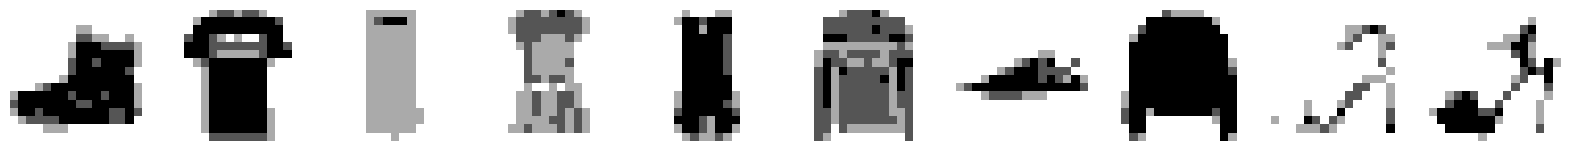

In [8]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4

# Function to preprocess the images
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


# Preprocess the training data
input_data, output_data = preprocess(x_train)

# Display some sample preprocessed images
display(input_data)

### Define PixelCNN

#### Define Masked Convolutional Layers

In [13]:
# Type A: value of the central pixel is masked
# Type B: value of the central pixel is not masked
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)    # Based on regular Conv2D layer

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.shape
        self.mask = np.zeros(shape=kernel_shape)   # Intialize mask with zeros
        self.mask[: kernel_shape[0] // 2, ...] = 1.0  # preceding rows set to 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B": # Type B: central pixel is not masked
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)  # Multiply the mask with filter weights
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

#### Define Residual Blocks 

In [11]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

#### Define PixelCNN itself

In [14]:
N_FILTERS = 128    # Number of filters in the convolutional layers
RESIDUAL_BLOCKS = 5   # Number of residual blocks in the network

# Define the PixelCNN model
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_2 (MaskedConv2D)  │ (None, 16, 16, 128)    │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 16, 16, 128)    │        53,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_8 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_9 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,460 (1.17 MB)

 Trainable params: 307,460 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

### Train the PixelCNN

In [15]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [16]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.6387

FileNotFoundError: [Errno 2] No such file or directory: './output/generated_img_000.png'

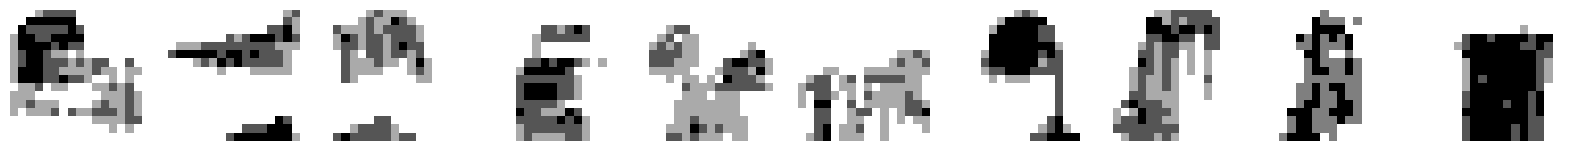

In [17]:
BATCH_SIZE = 128
EPOCHS = 150

# Train the PixelCNN model
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

### Generate Images

In [ ]:
generated_images = img_generator_callback.generate(temperature=1.0)
display(generated_images)